In [1]:
!pip install ujson

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 3.8 MB/s eta 0:00:00


In [7]:
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
from numpy.random import random, permutation, randn, normal, uniform, choice, randint

from scipy import ndimage
from scipy.ndimage import zoom

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_file, to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Input, Activation, Flatten, Dense, Dropout,
                                     BatchNormalization, Conv2D, MaxPooling2D)
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.metrics import categorical_crossentropy, categorical_accuracy
from tensorflow.keras.preprocessing import image, sequence
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50


In [8]:
def get_batches(dirname, gen = image.ImageDataGenerator(), shuffle = True, batch_size = 4, class_mode = 'categorical', target_size = (224,224)):
    return gen.flow_from_directory(dirname, target_size=target_size, class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

def get_data(path, target_size=(224,224)):
    batches = get_batches(path, shuffle=False, batch_size=1, class_mode=None, target_size=target_size)
    return np.concatenate([batches.next() for i in range(batches.samples)])

def plot_log_loss(loss_list, val_loss_list, title = 'log10(model loss)'):
    plt.plot(np.log10(loss_list))
    plt.plot(np.log10(val_loss_list))
    plt.title(title)
    plt.ylabel('log10(loss)')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

def do_clip(arr, mx):
    return np.clip(arr, (1-mx)/7, mx)

def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()

def load_array(fname):
    return bcolz.open(fname)[:]

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
path = "/content/drive/My Drive/Data/intel-image-classification/"

In [11]:
batch_size = 64
batches = get_batches(path+'seg_train', batch_size=batch_size)
test_batches = get_batches(path+'seg_test', batch_size=batch_size, shuffle=False)

Found 14044 images belonging to 1 classes.
Found 3010 images belonging to 1 classes.


In [12]:
print("Training set (images) shape: {shape}".format(shape = batches.image_shape))
print("Training set (images) input: {input}".format(input = batches.classes.size))
print("Training set (images) class: {classes}".format(classes = batches.num_classes))
print("Training set (images) labels: {classes}".format(classes = batches.class_indices))
print("\n")
print("Test set (images) shape: {shape}".format(shape = test_batches.image_shape))
print("Test set (images) input: {input}".format(input = test_batches.classes.size))
print("Test set (images) labels: {classes}".format(classes = test_batches.num_classes))
print("Test set (images) class: {classes}".format(classes = test_batches.class_indices))

Training set (images) shape: (224, 224, 3)
Training set (images) input: 14044
Training set (images) class: 1
Training set (images) labels: {'seg_train': 0}


Test set (images) shape: (224, 224, 3)
Test set (images) input: 3010
Test set (images) labels: 1
Test set (images) class: {'seg_test': 0}


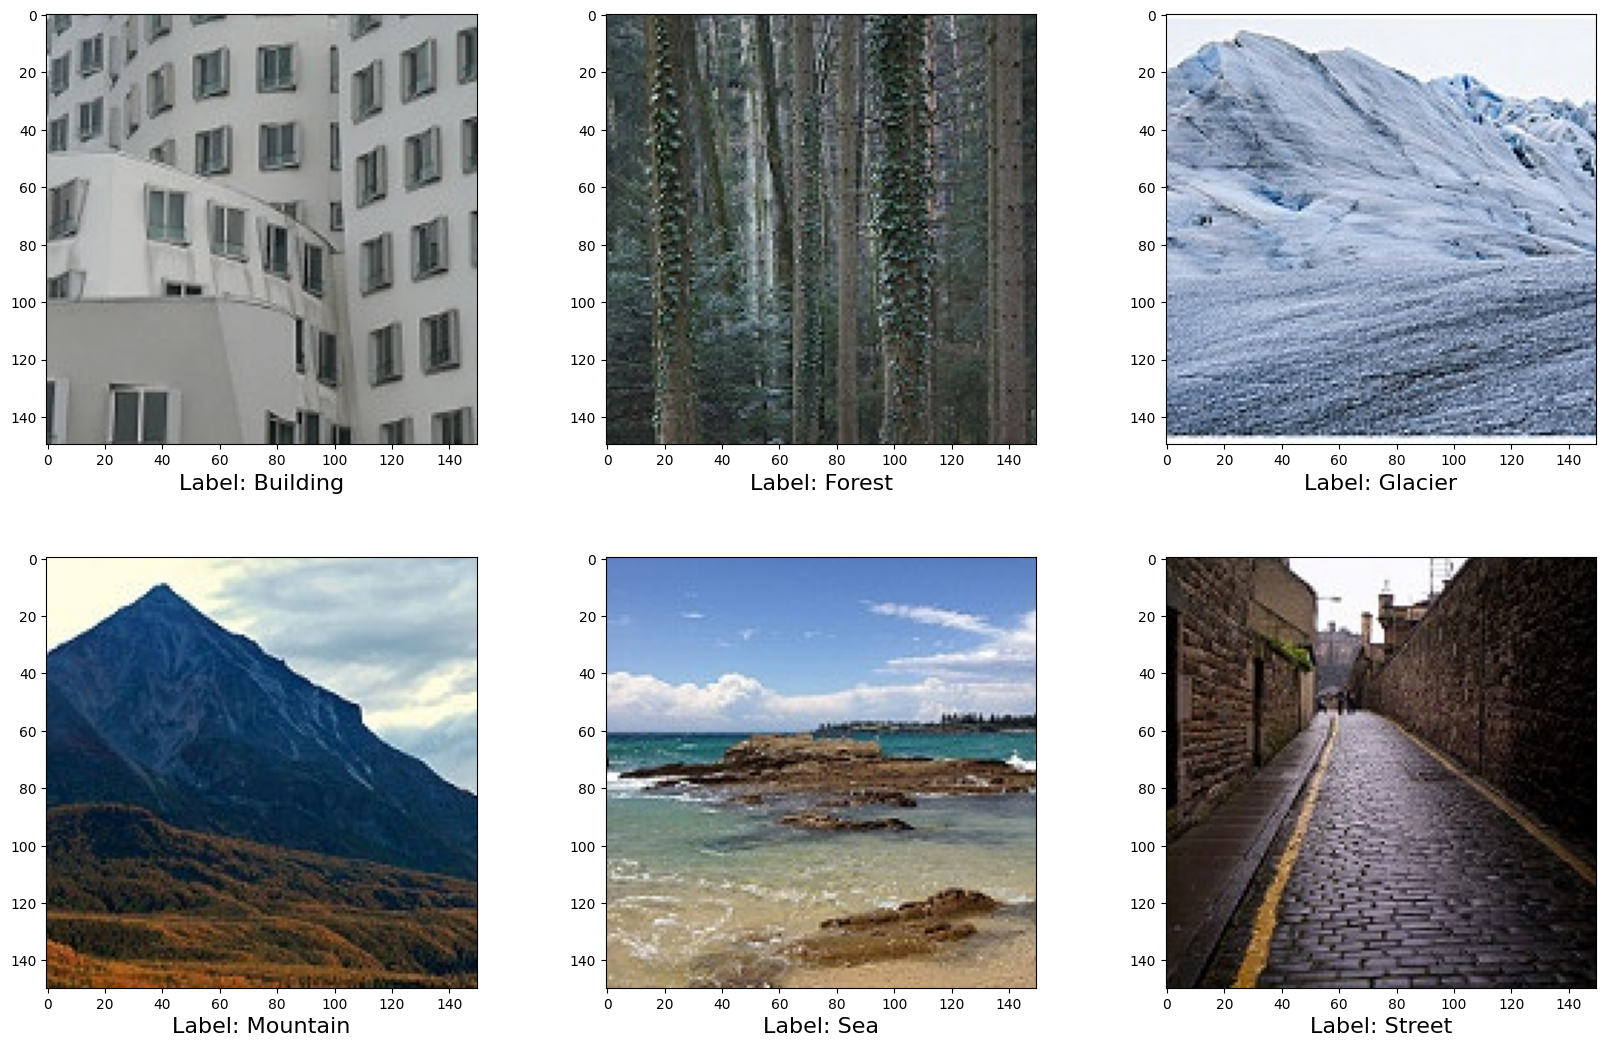

In [13]:
%matplotlib inline
img_path1 = path + 'seg_train/seg_train/buildings/' + os.listdir(path+'seg_train/seg_train/buildings')[1]
img1 = np.expand_dims(imread(img_path1),0)
img_path2 = path + 'seg_train/seg_train/forest/' + os.listdir(path+'seg_train/seg_train/forest')[1]
img2 = np.expand_dims(imread(img_path2),0)
img_path3 = path + 'seg_train/seg_train/glacier/' + os.listdir(path+'seg_train/seg_train/glacier')[1]
img3 = np.expand_dims(imread(img_path3),0)
img_path4 = path + 'seg_train/seg_train/mountain/' + os.listdir(path+'seg_train/seg_train/mountain')[1]
img4 = np.expand_dims(imread(img_path4),0)
img_path5 = path + 'seg_train/seg_train/sea/' + os.listdir(path+'seg_train/seg_train/sea')[1]
img5 = np.expand_dims(imread(img_path5),0)
img_path6 = path + 'seg_train/seg_train/street/' + os.listdir(path+'seg_train/seg_train/street')[1]
img6 = np.expand_dims(imread(img_path6),0)

f = plt.figure(figsize=(20,20))
ax1 = f.add_subplot(231)
ax2 = f.add_subplot(232)
ax3 = f.add_subplot(233)
ax4 = f.add_subplot(131)
ax5 = f.add_subplot(132)
ax6 = f.add_subplot(133)

ax1.imshow(img1[0])
ax2.imshow(img2[0])
ax3.imshow(img3[0])
ax4.imshow(img4[0])
ax5.imshow(img5[0])
ax6.imshow(img6[0])

ax1.set_xlabel("Label: Building",fontsize=16)
ax2.set_xlabel("Label: Forest"  ,fontsize=16)
ax3.set_xlabel("Label: Glacier" ,fontsize=16)
ax4.set_xlabel("Label: Mountain",fontsize=16)
ax5.set_xlabel("Label: Sea"     ,fontsize=16)
ax6.set_xlabel("Label: Street"  ,fontsize=16)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=1.4)
plt.show()

In [14]:
#dropout probability
p = 0.4

layers = [
    BatchNormalization(axis=1, input_shape=(224,224,3)),

    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(axis=1),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(axis=1),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(axis=1),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(axis=1),

    #Conv2D(512, (3, 3), activation='relu', padding='same'),
    #BatchNormalization(axis=1),
    #Conv2D(512, (3, 3), activation='relu', padding='same'),
    #BatchNormalization(axis=1),
    #MaxPooling2D(pool_size=(2, 2)),
    Dropout(p/2),

    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(p),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(p/2),
    Dense(6, activation='softmax')
]

/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
from tensorflow.keras.optimizers import Adam
model = Sequential(layers)
model.compile(Adam(learning_rate=0.001),
              loss = 'categorical_crossentropy', metrics=['accuracy'])
loss_list = []
val_loss_list = []

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

batches = train_datagen.flow_from_directory(
    '/content/drive/My Drive/Data/intel-image-classification/seg_train/seg_train',
    target_size=(224, 224),
    batch_size=32,                 # ✅ ADDED
    class_mode='categorical'       # required for softmax output
)

test_batches = test_datagen.flow_from_directory(
    '/content/drive/My Drive/Data/intel-image-classification/seg_test/seg_test',
    target_size=(224, 224),
    batch_size=32,                 # ✅ ADDED
    class_mode='categorical'
)

model_fit = model.fit(
    batches,
    steps_per_epoch=50,
    validation_data=test_batches,
    validation_steps=10,
    epochs=10
)

loss_list += model_fit.history['loss']
val_loss_list += model_fit.history['val_loss']

Found 14044 images belonging to 6 classes.
Found 3010 images belonging to 6 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 577s 11s/step - accuracy: 0.4312 - loss: 1.8300 - val_accuracy: 0.1531 - val_loss: 5.6254
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 498s 10s/step - accuracy: 0.5534 - loss: 1.2707 - val_accuracy: 0.2469 - val_loss: 3.3716
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 424s 9s/step - accuracy: 0.6143 - loss: 1.0591 - val_accuracy: 0.2750 - val_loss: 4.6204
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 316s 6s/step - accuracy: 0.5916 - loss: 1.0893 - val_accuracy: 0.3281 - val_loss: 2.5547
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 319s 7s/step - accuracy: 0.6173 - loss: 1.0587 - val_accuracy: 0.3844 - val_loss: 2.0499
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 228s 5s/step - accuracy: 0.6568 - loss: 0.9688 - val_accuracy: 0.5375 - val_loss: 1.3057
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 216s 4s/step - accuracy: 0.6730 - loss: 0.8844 - val_accuracy: 0.6469 - val_loss: 0.9348
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 181s 4s/step - accuracy: 0.6940 - loss: 0.8761 - val_accuracy: 0.7406 -

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


50/50 ━━━━━━━━━━━━━━━━━━━━ 130s 3s/step - accuracy: 0.6758 - loss: 0.8415 - val_accuracy: 0.7031 - val_loss: 0.7573
Epoch 10/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 208s 4s/step - accuracy: 0.7180 - loss: 0.7593 - val_accuracy: 0.6438 - val_loss: 0.9325


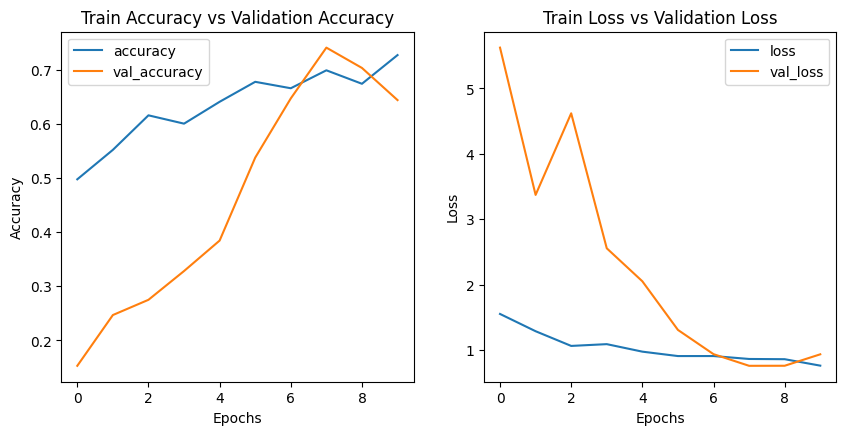

In [22]:

fig = plt.figure(figsize=(10, 10))

# Plot accuracy
plt.subplot(221)
plt.plot(model_fit.history["accuracy"], label="accuracy")         # ✅ fixed key
plt.plot(model_fit.history["val_accuracy"], label="val_accuracy") # ✅ fixed key
plt.title("Train Accuracy vs Validation Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot loss
plt.subplot(222)
plt.plot(model_fit.history["loss"], label="loss")
plt.plot(model_fit.history["val_loss"], label="val_loss")
plt.title("Train Loss vs Validation Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

plt.show()

In [24]:

# Replace this with your actual path
path = '/content/drive/My Drive/Data/intel-image-classification/'

# Set up the prediction generator
pred_datagen = ImageDataGenerator(rescale=1./255)

pred_batches = pred_datagen.flow_from_directory(
    path + 'seg_pred',
    target_size=(224, 224),
    batch_size=1,
    class_mode=None,
    shuffle=False
)

# Make predictions directly from the generator
pred_preds = model.predict(pred_batches, steps=pred_batches.samples)

# Extract file names (adjusting for Linux paths)
pred_filenames = [os.path.basename(f) for f in pred_batches.filenames]

Found 7301 images belonging to 1 classes.
7301/7301 ━━━━━━━━━━━━━━━━━━━━ 171s 23ms/step


In [25]:
#clip data to avoid overconfidence
pred_preds_clip = do_clip(pred_preds,0.82)

In [26]:
#create dataframe of predictions and write to csv
pred_preds_df = pd.DataFrame(pred_preds_clip, columns = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'])
pred_preds_df['predict'] = pred_preds_df.apply(lambda x:x[(x==x.max())].index.to_series().sample(frac=1).iloc[0], axis=1)
pred_preds_df['image'] = pred_filenames
pred_preds_df.head(6)

buildings    forest   glacier  mountain       sea    street   predict  \
0   0.120419  0.235178  0.074367  0.170944  0.025714  0.373458    street   
1   0.025714  0.025714  0.025714  0.820000  0.025714  0.025714  mountain   
2   0.156693  0.025714  0.025714  0.025714  0.025714  0.820000    street   
3   0.025714  0.025714  0.025714  0.820000  0.025714  0.025714  mountain   
4   0.025714  0.025714  0.184686  0.768954  0.025714  0.025714  mountain   
5   0.025714  0.820000  0.025714  0.025714  0.025714  0.025714    forest   

       image  
0  10004.jpg  
1  10005.jpg  
2  10012.jpg  
3  10013.jpg  
4  10017.jpg  
5  10021.jpg

In [27]:
pred_preds_df.to_csv('predicted images.csv', index = False,
                     columns = ["image",'buildings', 'forest', 'glacier', 'mountain', 'sea', 'street',"predict"])

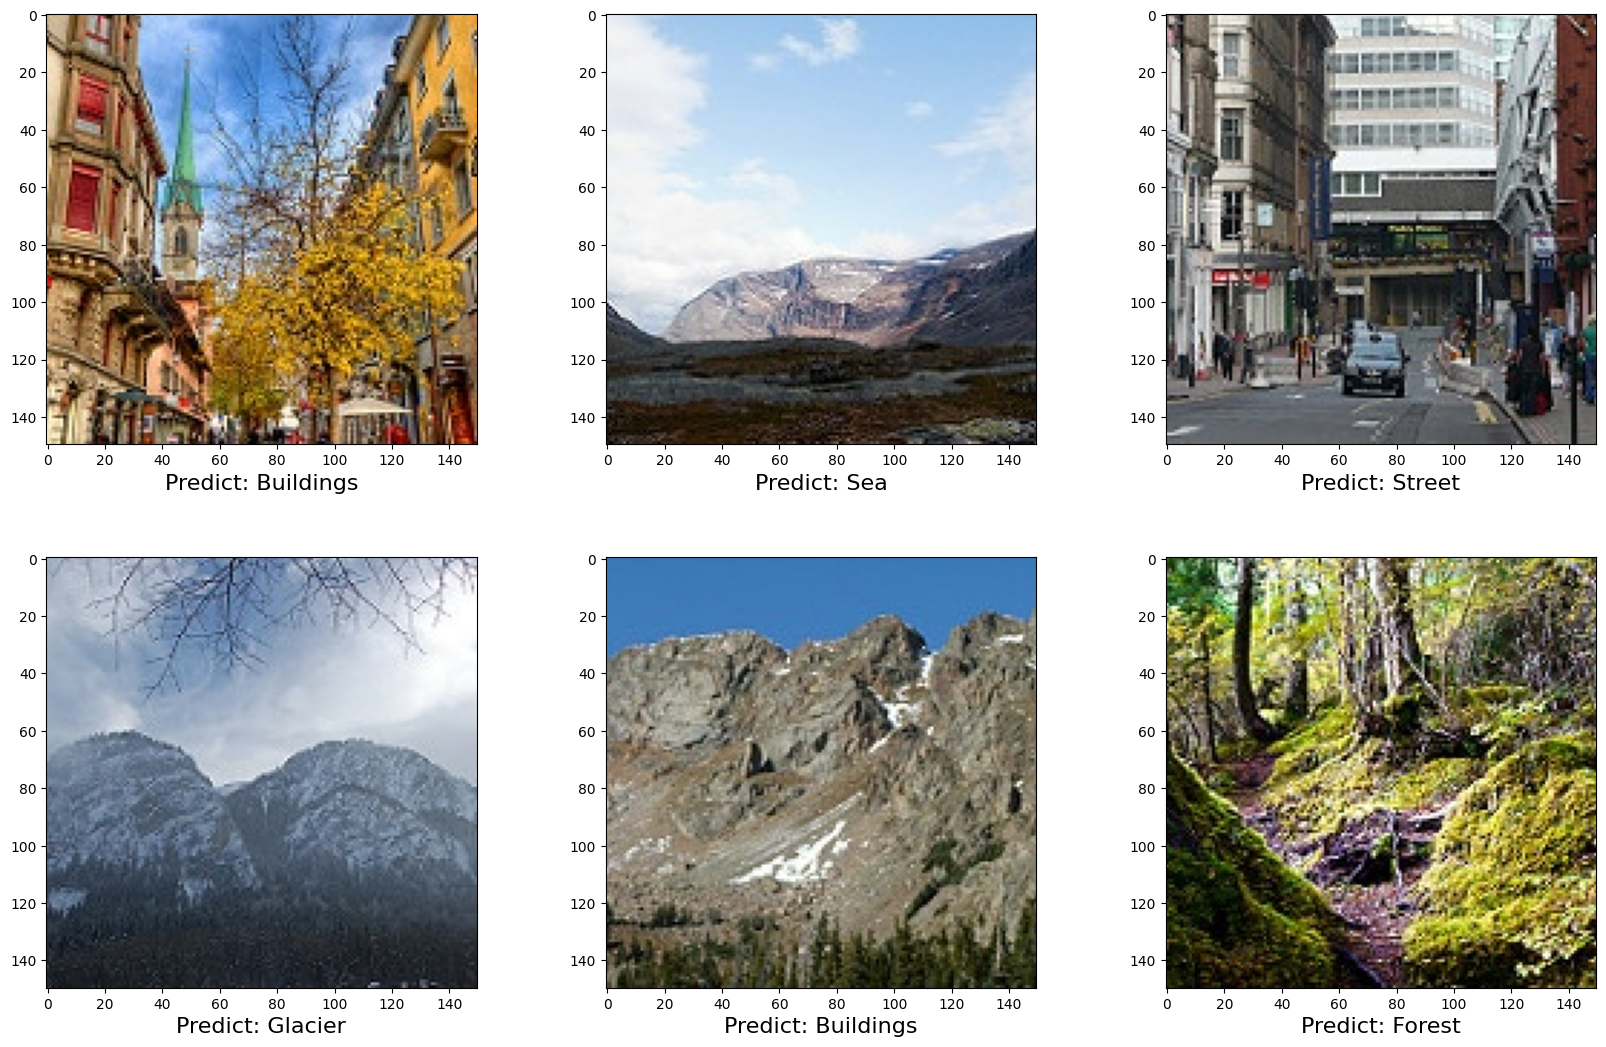

In [28]:
%matplotlib inline
img_path1 = path + 'seg_pred/seg_pred/10004.jpg'
img1 = np.expand_dims(imread(img_path1),0)
img_path2 = path + 'seg_pred/seg_pred/10005.jpg'
img2 = np.expand_dims(imread(img_path2),0)
img_path3 = path + 'seg_pred/seg_pred/10012.jpg'
img3 = np.expand_dims(imread(img_path3),0)
img_path4 = path + 'seg_pred/seg_pred/10013.jpg'
img4 = np.expand_dims(imread(img_path4),0)
img_path5 = path + 'seg_pred/seg_pred/10017.jpg'
img5 = np.expand_dims(imread(img_path5),0)
img_path6 = path + 'seg_pred/seg_pred/10021.jpg'
img6 = np.expand_dims(imread(img_path6),0)


f = plt.figure(figsize=(20,20))

ax1 = f.add_subplot(231)
ax2 = f.add_subplot(232)
ax3 = f.add_subplot(233)
ax4 = f.add_subplot(131)
ax5 = f.add_subplot(132)
ax6 = f.add_subplot(133)

ax1.imshow(img1[0])
ax2.imshow(img2[0])
ax3.imshow(img3[0])
ax4.imshow(img4[0])
ax5.imshow(img5[0])
ax6.imshow(img6[0])

ax1.set_xlabel("Predict: Buildings",fontsize=16)
ax2.set_xlabel("Predict: Sea" ,fontsize=16)
ax3.set_xlabel("Predict: Street"   ,fontsize=16)
ax4.set_xlabel("Predict: Glacier" ,fontsize=16)
ax5.set_xlabel("Predict: Buildings"  ,fontsize=16)
ax6.set_xlabel("Predict: Forest"   ,fontsize=16)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=1.4)
plt.show()

In [29]:
pred_preds_df.head(6)

buildings    forest   glacier  mountain       sea    street   predict  \
0   0.120419  0.235178  0.074367  0.170944  0.025714  0.373458    street   
1   0.025714  0.025714  0.025714  0.820000  0.025714  0.025714  mountain   
2   0.156693  0.025714  0.025714  0.025714  0.025714  0.820000    street   
3   0.025714  0.025714  0.025714  0.820000  0.025714  0.025714  mountain   
4   0.025714  0.025714  0.184686  0.768954  0.025714  0.025714  mountain   
5   0.025714  0.820000  0.025714  0.025714  0.025714  0.025714    forest   

       image  
0  10004.jpg  
1  10005.jpg  
2  10012.jpg  
3  10013.jpg  
4  10017.jpg  
5  10021.jpg